In [ ]:
import os
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Allow processing of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to remove corrupted images
def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.verify()  # Verify if the file is a valid image
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted image: {img_path}")
                os.remove(img_path)


In [ ]:
# Paths to dataset
train_data_dir = "Dataset/train/"
validation_data_dir = "Dataset/val/"

# Verify and clean dataset
verify_images(train_data_dir)
verify_images(validation_data_dir)

In [ ]:

# Model Parameters
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32
EPOCHS = 25


In [ ]:

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 15968 images belonging to 2 classes.
Found 3476 images belonging to 2 classes.


class_indices : {'biodegradable': 0, 'non_biodegradable': 1}
class_names : {0: 'biodegradable', 1: 'non_biodegradable'}
Displaying some training images...


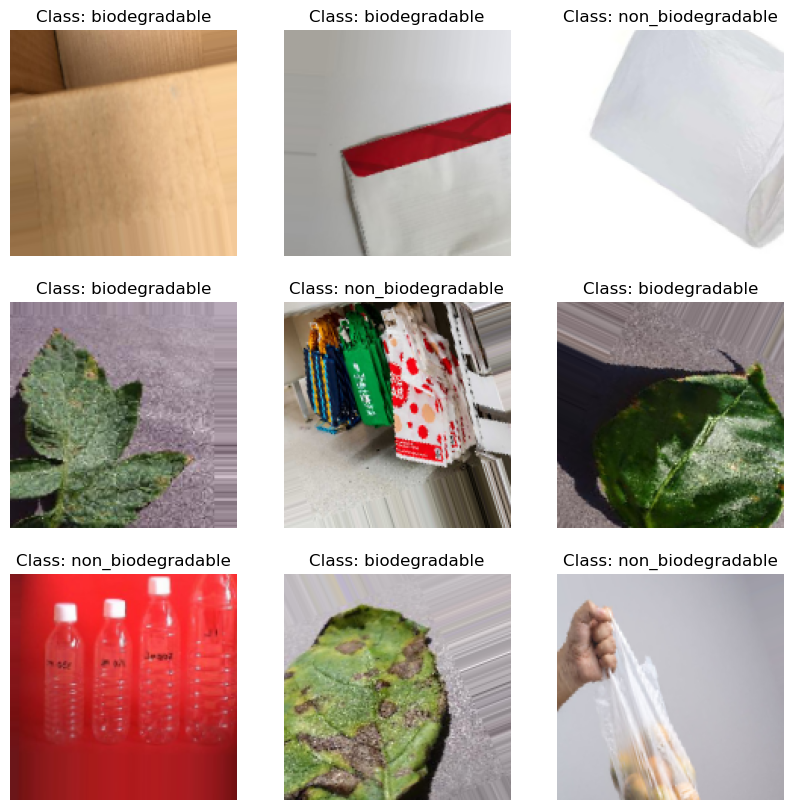

In [ ]:
# Map class indices to class names
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

print('class_indices :',class_indices)
print('class_names :',class_names)

# Display some training images
def show_sample_images(generator, num_images=9):
    images, labels = next(generator)  # Get a batch of images and labels
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        class_name = class_names[np.argmax(labels[i])]  # Map label to class name
        plt.title(f"Class: {class_name}")
    plt.show()

print("Displaying some training images...")
show_sample_images(train_generator)

In [ ]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# Callbacks
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)


In [ ]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping_cb, reduce_lr_cb]
)

# Save the model
cnn_model.save("cnn_model.h5")

print("Model training completed and saved as cnn_model.h5.")


Found 15968 images belonging to 2 classes.
Found 3476 images belonging to 2 classes.


D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
 40/499 ━━━━━━━━━━━━━━━━━━━━ 4:48 629ms/step - accuracy: 0.5971 - loss: 0.8386

D:\Anaconda\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


499/499 ━━━━━━━━━━━━━━━━━━━━ 327s 653ms/step - accuracy: 0.7634 - loss: 0.5058 - val_accuracy: 0.8050 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 330s 660ms/step - accuracy: 0.8409 - loss: 0.3770 - val_accuracy: 0.7827 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 333s 667ms/step - accuracy: 0.8492 - loss: 0.3489 - val_accuracy: 0.8484 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 3178s 6s/step - accuracy: 0.8511 - loss: 0.3352 - val_accuracy: 0.8605 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 327s 656ms/step - accuracy: 0.8616 - loss: 0.3198 - val_accuracy: 0.8302 - val_loss: 0.3601 - learning_rate: 0.0010
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 340s 681ms/step - accuracy: 0.8744 - loss: 0.2954 - val_accuracy: 0.8096 - val_loss: 0.4799 - learning_rate: 0.0010
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 352s 705ms/step - accuracy: 0.8763 - 

Model training completed and saved as cnn_model.h5.


In [ ]:
# Save the model
cnn_model.save("cnn_model1.h5")

In [ ]:
# Print Final Accuracy
train_acc = cnn_history.history['accuracy'][-1] * 100
val_acc = cnn_history.history['val_accuracy'][-1] * 100
print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")


Final Training Accuracy: 93.10%
Final Validation Accuracy: 88.48%


Displaying Training and Validation Accuracy and Loss...


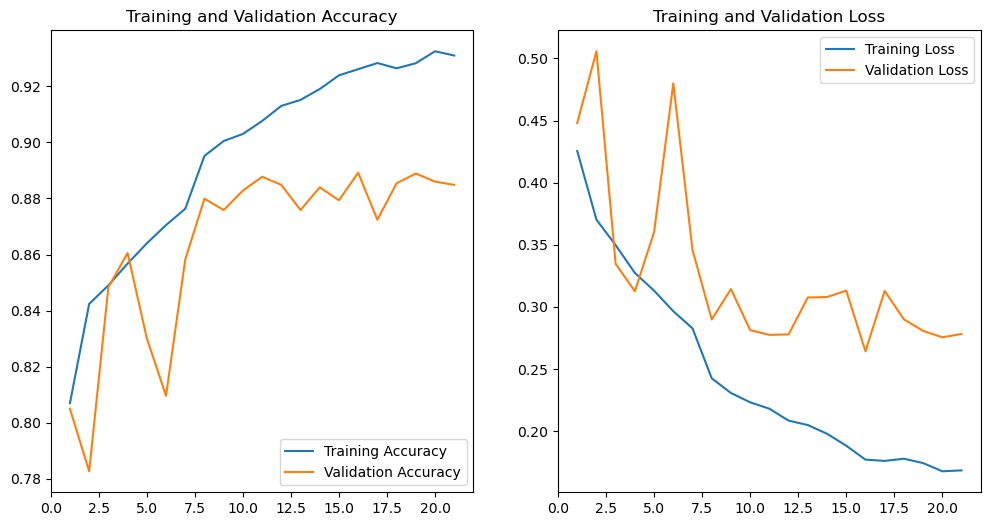

In [ ]:

# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    epochs_range = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
    plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label="Training Loss")
    plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    plt.show()

print("Displaying Training and Validation Accuracy and Loss...")
plot_training_history(cnn_history)